In [2]:
# All pre-requisites for running the codes. Assumes that CUDA version of pytorch is installed
import seaborn as sns
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import segyio
from shutil import copyfile
from numpy import genfromtxt

import torch 
import torch.nn as nn
import torch.autograd 
from torch.autograd import Variable
from random import randint
import torch.nn.functional as F

import scipy.stats as stats
import math

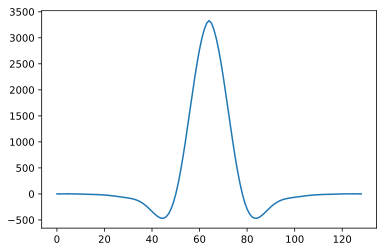

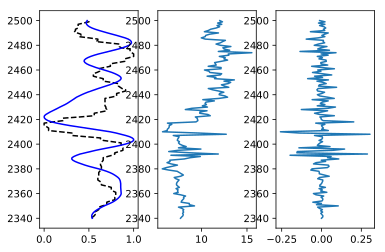

In [3]:
# Loading Impedance and seismic along well and checking if seismic using convolution matches the real seismic 

# Load seismic trace
seismic_data = genfromtxt('seismic_trace_15_9_F-15-A.csv', delimiter=';')

time_seismic = -np.round(seismic_data[:,0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)
dt_seismic = time_seismic[1] - time_seismic[0]

seismic_trace = seismic_data[unique_indices,1]
Ip_trace = seismic_data[unique_indices,2]

start_time = 2340.0
end_time = 2500.0

seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]


# Load statistical source wavelet
source_statistical = genfromtxt('statistical_source_wavelet.txt', delimiter='	')
dt_source = 1e-3
plt.plot(source_statistical[:,1])
plt.show()


# Convolution of source with reflectivity series 
r0 = 0.5*np.diff(np.log(Ip_trace_cropped))
r0 = np.insert(r0,0, 0)
ss = np.convolve(r0, source_statistical[:,1], mode='same')
ss_normalized = (ss - np.min(ss))/(np.max(ss) - np.min(ss))

fig, axs = plt.subplots(1,3)
axs[0].plot(seismic_trace_cropped, time_cropped, '--k' )
axs[0].plot(1-ss_normalized, time_cropped, '-b' )
axs[1].plot(Ip_trace_cropped, time_cropped)
axs[2].plot(r0, time_cropped)
plt.show()


# Note to match 1-ss_normalized from impedance inversion

In [4]:
# Load stochastically generated impedance 
Ip = np.loadtxt('Ip_exported.txt')
Ip_reshape = np.reshape(Ip, ((151,151,160)), order='F')

In [4]:
# Trace by trace normalization and convolution 
ss_new = np.zeros(Ip_reshape.shape)
Ip_normalized = np.zeros(Ip_reshape.shape)
for i in range(Ip_reshape.shape[0]):
#     print('Iteration no: '+ str(i) + ' / '+ str(Ip_reshape.shape[0]))
    for j in range(Ip_reshape.shape[1]):
        Ip_trace = Ip_reshape[i,j,:]
        Ip_normalized[i,j,:] = (Ip_trace - np.min(Ip_trace))/(np.max(Ip_trace) - np.min(Ip_trace))
        r0_trace = 0.5*np.diff(np.log(Ip_trace))
        r0_trace = np.insert(r0_trace,0, 0)
        ss_trace = np.convolve(r0_trace, source_statistical[:,1], mode='same')
        ss_new[i,j,:] = (ss_trace - np.min(ss_trace))/(np.max(ss_trace) - np.min(ss_trace))
        
        


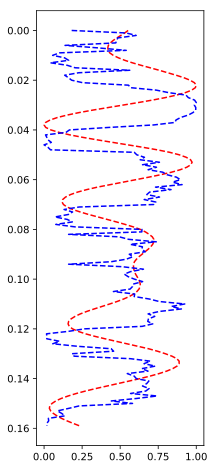

In [5]:
# Plot of results of convolution
time_new = np.arange(0,ss_new.shape[2]*1e-3, 1e-3)
nx = 100
ny = 100
# Ip_trace_normalized = (Ip_reshape[nx, ny, :] - np.min(Ip_reshape[nx, ny, :] ))/(np.max(Ip_reshape[nx, ny, :] ) - np.min(Ip_reshape[nx, ny, :] ))

plt.figure(num=None, figsize=(3, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ss_new[nx,ny,:], time_new, '--r')
plt.plot(Ip_normalized[nx,ny,:], time_new, '--b')
plt.gca().invert_yaxis()

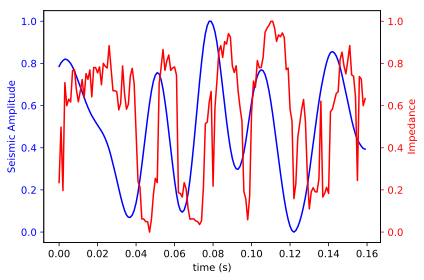

In [6]:
# Creating training, validation and test data 

# Validation dataset created near the area of the well
indx_i_well_start = 20
indx_i_well_end = 45
indx_j_well_start = 32
indx_j_well_end = 54
valX = ss_new[indx_i_well_start:indx_i_well_end, indx_j_well_start:indx_j_well_end, :]
valX = valX.reshape(-1, valX.shape[-1])
valX = torch.FloatTensor(np.reshape(valX, (valX.shape[0], 1, valX.shape[1])))

valIp = Ip_normalized[indx_i_well_start:indx_i_well_end, indx_j_well_start:indx_j_well_end, :]
valIp = valIp.reshape(-1, valIp.shape[-1])
valIp = torch.FloatTensor(np.reshape(valIp, (valIp.shape[0], 1, valIp.shape[1])))


# Flatten rest of indices 
ss_data_rest = ss_new[np.r_[0:(indx_i_well_start-1),(indx_i_well_end+1):ss_new.shape[0]], :, :]
ss_data_rest = ss_data_rest[:, np.r_[0:(indx_j_well_start-1),(indx_j_well_end+1):ss_new.shape[1]],:]
ss_data_rest = ss_data_rest.reshape(-1, ss_data_rest.shape[-1])

Ip_data_rest = Ip_normalized[np.r_[0:(indx_i_well_start-1),(indx_i_well_end+1):Ip_normalized.shape[0]], :, :]
Ip_data_rest = Ip_data_rest[:, np.r_[0:(indx_j_well_start-1),(indx_j_well_end+1):Ip_normalized.shape[1]],:]
Ip_data_rest = Ip_data_rest.reshape(-1, Ip_data_rest.shape[-1])

# Selecting randomly training dataset
howMany = 750 # Seismic data considered out of all data points 
np.random.seed(9) # For replication of results
indxRand = [randint(0,ss_data_rest.shape[0]-1) for p in range(0,howMany)]

trainX = (ss_data_rest[indxRand, :])
trainX = torch.FloatTensor(np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])))

trainIp = (Ip_data_rest[indxRand, :])
trainIp = torch.FloatTensor(np.reshape(trainIp, (trainIp.shape[0], 1, trainIp.shape[1])))

sampleNumber = 100
time = np.arange(0, trainX.shape[2]*1e-3, 1e-3)
fig, ax1 = plt.subplots()
ax1.plot(time, trainX[sampleNumber,0,:].numpy(), 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Seismic Amplitude', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(time, trainIp[sampleNumber,0,:].numpy(), 'r-')
ax2.set_ylabel('Impedance', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()


In [7]:
# Hyperparameters for the CNN
num_epochs = 500
batch_size = 1
learning_rate = 0.0001

noOfNeurons = 60
dilation = 1
kernel_size = 80
stride = 1
padding = int(((dilation*(kernel_size-1)-1)/stride-1)/2)
print("Padding size {}".format(padding))

class rcs2impcnn(nn.Module):
    def __init__(self):
        super(rcs2impcnn, self).__init__()

    def forward(self, x, ipp):
        return ipp*torch.exp(2*torch.cumsum(x,2)).cuda()


# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            # input, output, kernel, stride  ...  kernel_size<stride+traces.shape[2]
#            Lin+2∗padding−dilation∗(kernel_size−1)−1)/stride+1
            nn.Conv1d(1, noOfNeurons, kernel_size=kernel_size, stride=1, padding = padding+1),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv1d(noOfNeurons, 1, kernel_size=kernel_size, stride=1, padding = padding+2),
            nn.ReLU())
#         self.layer1 = nn.Sequential(
#             # input, output, kernel, stride  ...  kernel_size<stride+traces.shape[2]
# #            Lin+2∗padding−dilation∗(kernel_size−1)−1)/stride+1
#             nn.Conv1d(1, noOfNeurons, kernel_size=kernel_size, stride=1, padding = padding+1),
#             nn.ReLU(),
#             nn.Conv1d(noOfNeurons, 1, kernel_size=kernel_size, stride=1, padding = padding+2),
#             nn.Tanh())
#         self.rcs2imp = rcs2impcnn()    

    

    def forward(self, x):
        out = self.layer1(x)
        # out = F.tanh(self.layer2(out))
        out = self.layer2(out)
        # out = out.view(out.size(0), -1)

#         ipp = ipp.repeat(1,1,out.size()[2])
#         ipp = ipp.permute(1, 0, 2)
#         out = self.rcs2imp(out,ipp)

        
#        out = self.fc(out)

        return out

cnn = CNN()
cnn.cuda() 

Padding size 38


CNN(
  (layer1): Sequential(
    (0): Conv1d (1, 60, kernel_size=(80,), stride=(1,), padding=(39,))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv1d (60, 1, kernel_size=(80,), stride=(1,), padding=(40,))
    (1): ReLU()
  )
)

In [17]:
# Training the model

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

batch_size_tot = trainX.shape[0]
no_of_batches = (batch_size_tot - batch_size_tot%batch_size)/batch_size
no_of_batches = int(no_of_batches)

trainLosses = []   
valLosses = [] 

# Train the Model
for epoch in range(num_epochs):
        for ii in range(no_of_batches):
#            optimizer.zero_grad()
#            traces = Variable(trainX[ii*batch_size:(ii+1)*batch_size,:,:]).cuda()  
            # First value of Ip used if the loss criteria is impedance instead of reflection coefficients
            ipp = Variable(trainIp[ii*batch_size:(ii+1)*batch_size,:,0]).cuda()  
#            outputs = cnn(traces,ipp)
#            
#            outputs = outputs.view(batch_size, 1, outputs.size()[1])
#            yy = Variable(trainIp[ii*batch_size:(ii+1)*batch_size,:,:]).cuda();

            
            traces = Variable(trainX[ii*batch_size:(ii+1)*batch_size,:,:]).cuda()
        

            outputs = cnn(traces)
            
#            refl_train = Variable(trainY[ii*batch_size:(ii+1)*batch_size,:,:]).cuda()
            ipyy = Variable(trainIp[ii*batch_size:(ii+1)*batch_size,:,:]).cuda()
            
#             plt.plot(traces.data.cpu().numpy()[0,0,:], '-k')
#             plt.pause(0.05)

            loss = criterion(outputs, ipyy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        trainLosses.append(loss.data[0])

        #       Validation error      
        traces_val = Variable(valX).cuda()
        outputs_val = cnn(traces_val)
        ipyy_val = Variable(valIp).cuda()
        loss_val = criterion(outputs_val, ipyy_val)
        valLosses.append(loss_val.data[0]) 
        
        print ('Epoch [%d/%d], Iter [%d], Train Loss: %.6f, Validation Loss: %.6f' 
                   %(epoch+1, num_epochs, ii+1, loss.data[0], loss_val.data[0]))
        # Free up GPU memory
#         torch.cuda.empty_cache()

        
del traces
del outputs


Epoch [1/500], Iter [750], Train Loss: 0.076759, Validation Loss: 0.040069
Epoch [2/500], Iter [750], Train Loss: 0.062928, Validation Loss: 0.036525
Epoch [3/500], Iter [750], Train Loss: 0.056070, Validation Loss: 0.034834
Epoch [4/500], Iter [750], Train Loss: 0.051312, Validation Loss: 0.033791
Epoch [5/500], Iter [750], Train Loss: 0.047226, Validation Loss: 0.033050
Epoch [6/500], Iter [750], Train Loss: 0.044237, Validation Loss: 0.032465
Epoch [7/500], Iter [750], Train Loss: 0.041849, Validation Loss: 0.031972
Epoch [8/500], Iter [750], Train Loss: 0.040040, Validation Loss: 0.031563
Epoch [9/500], Iter [750], Train Loss: 0.038550, Validation Loss: 0.031207
Epoch [10/500], Iter [750], Train Loss: 0.037574, Validation Loss: 0.030878
Epoch [11/500], Iter [750], Train Loss: 0.036700, Validation Loss: 0.030581
Epoch [12/500], Iter [750], Train Loss: 0.035883, Validation Loss: 0.030316
Epoch [13/500], Iter [750], Train Loss: 0.035331, Validation Loss: 0.030068
Epoch [14/500], Iter 

Epoch [109/500], Iter [750], Train Loss: 0.017085, Validation Loss: 0.020091
Epoch [110/500], Iter [750], Train Loss: 0.017065, Validation Loss: 0.020044
Epoch [111/500], Iter [750], Train Loss: 0.016973, Validation Loss: 0.020002
Epoch [112/500], Iter [750], Train Loss: 0.016969, Validation Loss: 0.019966
Epoch [113/500], Iter [750], Train Loss: 0.016962, Validation Loss: 0.019920
Epoch [114/500], Iter [750], Train Loss: 0.016886, Validation Loss: 0.019885
Epoch [115/500], Iter [750], Train Loss: 0.016876, Validation Loss: 0.019848
Epoch [116/500], Iter [750], Train Loss: 0.016802, Validation Loss: 0.019810
Epoch [117/500], Iter [750], Train Loss: 0.016752, Validation Loss: 0.019767
Epoch [118/500], Iter [750], Train Loss: 0.016698, Validation Loss: 0.019733
Epoch [119/500], Iter [750], Train Loss: 0.016617, Validation Loss: 0.019692
Epoch [120/500], Iter [750], Train Loss: 0.016479, Validation Loss: 0.019659
Epoch [121/500], Iter [750], Train Loss: 0.016455, Validation Loss: 0.019619

Epoch [216/500], Iter [750], Train Loss: 0.014044, Validation Loss: 0.017867
Epoch [217/500], Iter [750], Train Loss: 0.014005, Validation Loss: 0.017855
Epoch [218/500], Iter [750], Train Loss: 0.014012, Validation Loss: 0.017843
Epoch [219/500], Iter [750], Train Loss: 0.013976, Validation Loss: 0.017831
Epoch [220/500], Iter [750], Train Loss: 0.013978, Validation Loss: 0.017823
Epoch [221/500], Iter [750], Train Loss: 0.013952, Validation Loss: 0.017815
Epoch [222/500], Iter [750], Train Loss: 0.013973, Validation Loss: 0.017807
Epoch [223/500], Iter [750], Train Loss: 0.013941, Validation Loss: 0.017794
Epoch [224/500], Iter [750], Train Loss: 0.013949, Validation Loss: 0.017782
Epoch [225/500], Iter [750], Train Loss: 0.013945, Validation Loss: 0.017772
Epoch [226/500], Iter [750], Train Loss: 0.013957, Validation Loss: 0.017765
Epoch [227/500], Iter [750], Train Loss: 0.013958, Validation Loss: 0.017756
Epoch [228/500], Iter [750], Train Loss: 0.013999, Validation Loss: 0.017752

Epoch [323/500], Iter [750], Train Loss: 0.013366, Validation Loss: 0.016964
Epoch [324/500], Iter [750], Train Loss: 0.013335, Validation Loss: 0.016960
Epoch [325/500], Iter [750], Train Loss: 0.013351, Validation Loss: 0.016951
Epoch [326/500], Iter [750], Train Loss: 0.013355, Validation Loss: 0.016946
Epoch [327/500], Iter [750], Train Loss: 0.013351, Validation Loss: 0.016938
Epoch [328/500], Iter [750], Train Loss: 0.013349, Validation Loss: 0.016928
Epoch [329/500], Iter [750], Train Loss: 0.013363, Validation Loss: 0.016924
Epoch [330/500], Iter [750], Train Loss: 0.013360, Validation Loss: 0.016917
Epoch [331/500], Iter [750], Train Loss: 0.013361, Validation Loss: 0.016912
Epoch [332/500], Iter [750], Train Loss: 0.013354, Validation Loss: 0.016904
Epoch [333/500], Iter [750], Train Loss: 0.013370, Validation Loss: 0.016895
Epoch [334/500], Iter [750], Train Loss: 0.013323, Validation Loss: 0.016897
Epoch [335/500], Iter [750], Train Loss: 0.013348, Validation Loss: 0.016887

Epoch [430/500], Iter [750], Train Loss: 0.013183, Validation Loss: 0.016234
Epoch [431/500], Iter [750], Train Loss: 0.013233, Validation Loss: 0.016227
Epoch [432/500], Iter [750], Train Loss: 0.013211, Validation Loss: 0.016223
Epoch [433/500], Iter [750], Train Loss: 0.013228, Validation Loss: 0.016219
Epoch [434/500], Iter [750], Train Loss: 0.013241, Validation Loss: 0.016206
Epoch [435/500], Iter [750], Train Loss: 0.013240, Validation Loss: 0.016207
Epoch [436/500], Iter [750], Train Loss: 0.013255, Validation Loss: 0.016196
Epoch [437/500], Iter [750], Train Loss: 0.013239, Validation Loss: 0.016188
Epoch [438/500], Iter [750], Train Loss: 0.013214, Validation Loss: 0.016195
Epoch [439/500], Iter [750], Train Loss: 0.013218, Validation Loss: 0.016184
Epoch [440/500], Iter [750], Train Loss: 0.013222, Validation Loss: 0.016175
Epoch [441/500], Iter [750], Train Loss: 0.013218, Validation Loss: 0.016166
Epoch [442/500], Iter [750], Train Loss: 0.013217, Validation Loss: 0.016163

In [26]:
# Save the Trained Model
with open('cnn_KernSize' + str(kernel_size) + '_NoOfNeurons' + str(noOfNeurons) + '_ForPaper.pkl', 'wb') as pickle_file:
     torch.save(cnn.state_dict(), pickle_file)
np.savez('lossdata.npz', name1=trainLosses, name2=valLosses)

In [8]:
# Loading the model
with open('cnn_KernSize' + str(kernel_size) + '_NoOfNeurons' + str(noOfNeurons) + '_ForPaper.pkl', 'rb') as pickle_file:
     cnn.load_state_dict(torch.load(pickle_file))

NameError: name 'trainLosses' is not defined

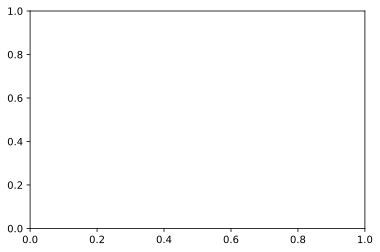

In [9]:
# Plotting the training + validation losses
fig, ax = plt.subplots()
ax.plot(trainLosses,'-k', label='Training Loss')
ax.plot(valLosses,'-r', label='Validation Loss')
legend = ax.legend(loc='upper right')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")

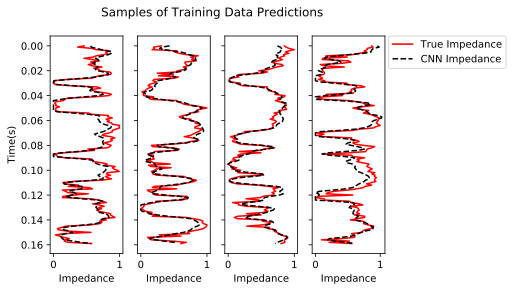

In [9]:
# Make one graph showing sample Training Data
sampleNumbers = np.array([2,54,123,209])

fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Samples of Training Data Predictions')

# Seismic traces
for i in range(4):
    sampleNumber = sampleNumbers[i];
    
    # Get an input seismic and impedance trace 
    TrainingSeismicTrace = Variable(trainX[sampleNumber:sampleNumber+1,:,:]).cuda()
    TrainingImpedanceTrace = Variable(trainIp[sampleNumber:sampleNumber+1,:,0]).cuda();
    # Calculate the impedance prediction
    CNN_ImpedancePrediction = cnn(TrainingSeismicTrace)

    #Now Get the numpy versions
    TrainingSeismicTrace = trainX[sampleNumber,:].numpy().transpose()
    TrainingImpedanceTrace = trainIp[sampleNumber,:].numpy().transpose()
    CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy().transpose()[:, 0,0]
#     # Back transforming to original values
#     TrainingImpedanceTrace1 = trainIp1[sampleNumber,:].numpy().transpose()
#     CNN_ImpedancePrediction1 = CNN_ImpedancePrediction * (np.max(TrainingImpedanceTrace1) - np.min(TrainingImpedanceTrace1)) + np.min(TrainingImpedanceTrace1)
    
    line1, = axs[i].plot(TrainingImpedanceTrace, time, 'r-')
    axs[i].set_xlabel('Impedance')
    if i==0:
        axs[i].set_ylabel('Time(s)')
    line2, = axs[i].plot(CNN_ImpedancePrediction, time, 'k--')
lgd = plt.legend((line1, line2), ('True Impedance', 'CNN Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


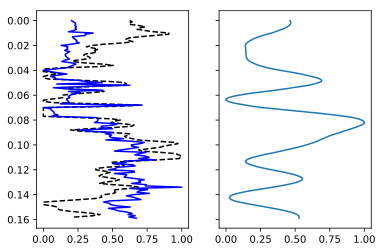

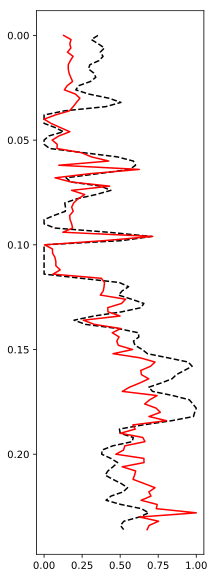

In [10]:
# Test with well impedance 
ss_normalized1 = ss_normalized[0:160]
testX_well = torch.FloatTensor(np.reshape(ss_normalized1, (1, 1, ss_normalized1.shape[0])))
TestingSetSeismicTrace = Variable(testX_well[:,:,:]).cuda()
# Calculate the impedance prediction
CNN_ImpedancePrediction = cnn(TestingSetSeismicTrace)

CNN_ImpedancePrediction = CNN_ImpedancePrediction.data.cpu().numpy()[0,0,:]

CNN_ImpedancePrediction_normalized = (CNN_ImpedancePrediction - np.min(CNN_ImpedancePrediction))/(np.max(CNN_ImpedancePrediction)-np.min(CNN_ImpedancePrediction))

time = np.arange(0, (Ip_trace_cropped.shape[0]-1)*1e-3, 1e-3)
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].invert_yaxis()
axs[0].plot(CNN_ImpedancePrediction_normalized,time, '--k')
Ip_trace_cropped_normalized = (Ip_trace_cropped[0:160] - np.min(Ip_trace_cropped))/(np.max(Ip_trace_cropped)-np.min(Ip_trace_cropped))
axs[0].plot(Ip_trace_cropped_normalized, time, '-b')
axs[1].plot(ss_normalized1, time)
plt.show()

time_new = np.arange(0,119*2e-3,2e-3)
plt.figure(num=None, figsize=(3, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(CNN_ImpedancePrediction_normalized[20:-1-20],time_new, '--k')
plt.plot(Ip_trace_cropped_normalized[20:-1-20], time_new, '-r')
plt.gca().invert_yaxis()
plt.show()

In [11]:
np.corrcoef(CNN_ImpedancePrediction_normalized[20:-1-20], Ip_trace_cropped_normalized[20:-1-20])

array([[1.        , 0.82133976],
       [0.82133976, 1.        ]])

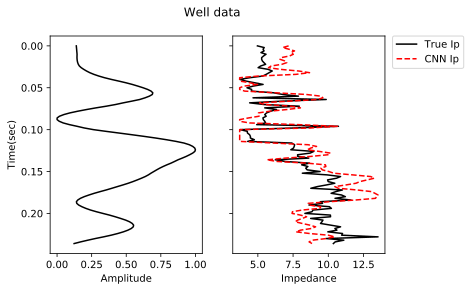

In [12]:
# Plot of true vs CNN impedance and true vs synthetic seismogram

time_new = np.arange(0,119*2e-3,2e-3)
Ip_well = Ip_trace_cropped_normalized[20:-1-20]
Ip_well_backtransformed = Ip_well * (np.max(Ip_trace_cropped) - np.min(Ip_trace_cropped)) + np.min(Ip_trace_cropped) -2

CNN_well = CNN_ImpedancePrediction_normalized[20:-1-20]
CNN_well_backtransformed = CNN_well * (np.max(Ip_trace_cropped) - np.min(Ip_trace_cropped)) + np.min(Ip_trace_cropped) -2

# Generating synthetic seismogram for both CNN and true impedance
r0_Ip_well = 0.5*np.diff(np.log(Ip_well_backtransformed))
r0_Ip_well = np.insert(r0_Ip_well,0, 0)
ss_Ip_well = np.convolve(r0_Ip_well, source_statistical[:-1-10,1], mode='same')
ss_Ip_well_normalized = (ss_Ip_well - np.min(ss_Ip_well))/(np.max(ss_Ip_well) - np.min(ss_Ip_well))

r0_CNN_well = 0.5*np.diff(np.log(CNN_well_backtransformed))
r0_CNN_well = np.insert(r0_CNN_well,0, 0)
ss_CNN_well = np.convolve(r0_CNN_well, source_statistical[:-1-10,1], mode='same')
ss_CNN_well_normalized = (ss_CNN_well - np.min(ss_CNN_well))/(np.max(ss_CNN_well) - np.min(ss_CNN_well))

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].invert_yaxis()
fig.suptitle('Well data')

axs[0].plot(ss_normalized1[20:-1-20], time_new, 'k-')
axs[0].set_xlabel('Amplitude')
axs[0].set_ylabel('Time(sec)')

line1, = axs[1].plot(Ip_well_backtransformed, time_new, 'k-')
line2, = axs[1].plot(CNN_well_backtransformed,time_new, 'r--')
axs[1].set_xlabel('Impedance')




lgd = plt.legend((line1, line2), ('True Ip', 'CNN Ip'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig.savefig('Figures/Well_data.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
